# Xarray-to-Zarr Sequential Recipe: NOAA OISST

This tutorial describes how to create a recipe from scratch.
The source data is a sequence of NetCDF files accessed via HTTP.
The target is a Zarr store.

## Step 1: Get to know your source data

If you are developing a new recipe, you are probably starting from an existing
dataset. The first step is to just get to know the dataset. For this tutorial,
our example will be the _NOAA Optimum Interpolation Sea Surface Temperature
(OISST) v2.1_. The authoritative website describing the data is
<https://www.ncdc.noaa.gov/oisst/optimum-interpolation-sea-surface-temperature-oisst-v21>.
This website contains links to the actual data files on the
[data access](https://www.ncdc.noaa.gov/oisst/data-access) page. We will use the
_AVHRR-Only_ version of the data and follow the corresponding link to the
[Gridded netCDF Data](https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/).
Browsing through the directories, we can see that there is one file per day. The
very first day of the dataset is stored at the following URL:

```text
https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc
```

From this example, we can work out the pattern of the file naming conventions.
But first, let's just download one of the files and open it up.


In [1]:
! wget https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc 

--2023-02-15 11:52:07--  https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.178, 205.167.25.172, 205.167.25.177, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1714749 (1.6M) [application/x-netcdf]
Saving to: ‘oisst-avhrr-v02r01.19810901.nc.1’

oisst-avhrr-v02r01. 100%[===================>]   1.63M   591KB/s    in 2.8s    

2023-02-15 11:52:11 (591 KB/s) - ‘oisst-avhrr-v02r01.19810901.nc.1’ saved [1714749/1714749]



In [2]:
import xarray as xr

ds = xr.open_dataset("oisst-avhrr-v02r01.19810901.nc")
ds

<xarray.Dataset>
Dimensions:  (time: 1, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 ...
    err      (time, zlev, lat, lon) float32 ...
    ice      (time, zlev, lat, lon) float32 ...
    sst      (time, zlev, lat, lon) float32 ...
Attributes: (12/37)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.19810901.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

We can see there are four data variables, all with dimension
`(time, zlev, lat, lon)`. There is a _dimension coordinate_ for each dimension,
and no _non-dimension coordinates_. Each file in the sequence presumably has the
same `zlev`, `lat`, and `lon`, but we expect `time` to be different in each one.

Let's also check the total size of the dataset in the file.


In [3]:
print(f"File size is {ds.nbytes/1e6} MB")

File size is 16.597452 MB


The file size is important because it will help us define the _chunk size_
Pangeo Forge will use to build up the target dataset.


## Step 2: Define File Pattern

The first step in developing a recipe is to define a {doc}`File Pattern <../../recipe_user_guide/file_patterns>`.
The file pattern describes how the source files (a.k.a. "inputs") are organized.

In this case, we have a very simple sequence of files that we want to concatenate along a single dimension (time), so we can use the helper function {func}`pangeo_forge_recipes.patterns.pattern_from_file_sequence`. This allows us to simply pass a list of URLs, which we define explicitly.

In [4]:
from pangeo_forge_recipes.patterns import pattern_from_file_sequence

pattern_from_file_sequence?

To populate the `file_list`, we need understand the file naming conventions. Let's look again at the first URL

```text
https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc
```

From this we deduce the following format string.

In [5]:
input_url_pattern = (
    "https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation"
    "/v2.1/access/avhrr/{yyyymm}/oisst-avhrr-v02r01.{yyyymmdd}.nc"
)

To convert this to an actual list of files, we use Pandas.
At the time of writing, the latest available data is from 2021-01-05.

In [6]:
import pandas as pd

dates = pd.date_range("1981-09-01", "2021-01-05", freq="D")
input_urls = [
    input_url_pattern.format(
        yyyymm=day.strftime("%Y%m"), yyyymmdd=day.strftime("%Y%m%d")
    )
    for day in dates
]
print(f"Found {len(input_urls)} files!")
input_urls[-1]

Found 14372 files!


'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202101/oisst-avhrr-v02r01.20210105.nc'

Now we can define our pattern.
We will include one more piece of information: we know from examining the file above that there is only one timestep per file.
So we can set `nitems_per_file=1`.

In [7]:
pattern = pattern_from_file_sequence(input_urls, "time", nitems_per_file=1)
pattern

<FilePattern {'time': 14372}>

To check out pattern, we can try to get the data back out.
The pattern is designed to be iterated over, so to key the first key, we do:

In [8]:
for key in pattern:
    break
key

{Dimension(name='time', operation=<CombineOp.CONCAT: 2>): Position(value=0, indexed=False)}

We can now use "getitem" syntax on the FilePattern object to retrieve the file name based on this key.

In [9]:
pattern[key]

'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'

As an alternative way to create the same pattern we could use the more verbose syntax to create a `FilePattern` class.
With this method, we have to define a function which returns the file path, given a particular key.
We might do it like this.

In [10]:
from pangeo_forge_recipes.patterns import ConcatDim, FilePattern

def format_function(time):
    return input_url_pattern.format(
        yyyymm=time.strftime("%Y%m"), yyyymmdd=time.strftime("%Y%m%d")
    )

concat_dim = ConcatDim(name="time", keys=dates, nitems_per_file=1)
pattern = FilePattern(format_function, concat_dim)
pattern

<FilePattern {'time': 14372}>

We can check that it gives us the same thing:

In [11]:
pattern[key]

'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'

## Step 3: Create storage target

Here we will create a temporary directory to write our output dataset to. We could also write to cloud storage.

In [12]:
from tempfile import TemporaryDirectory
td = TemporaryDirectory()
target_path = td.name + "/output.zarr"
target_path

'/tmp/tmpt6jylriq/output.zarr'

## Step 4: Write the Recipe

Now that we have a file pattern, we are ready to write our recipe. A recipe is defined as a pipeline of [Apache Beam transforms](https://beam.apache.org/documentation/programming-guide/#transforms) applied to the data collection associated with a `FilePattern`.

First, we'll import the transforms provided by Pangeo Forge that may be used to transform a `FilePattern` collection of NetCDF files into a Zarr store.

In [13]:
import apache_beam as beam
from pangeo_forge_recipes.transforms import OpenURLWithFSSpec, OpenWithXarray, StoreToZarr

### Define the Recipe Object
A recipe pipeline contains a set of transforms, which operate on an `apache_beam.PCollection`, performing a one-to-one mapping using `apache_beam.Map` of input elements to output elements, applying the specified transformation. For creating a Zarr store from a NetCDF collection, the recipe pipeline will contain the following transforms applied to the file pattern collection:
* `OpenURLWithFSSpec`: retrieves each pattern file using the specified URLs.
* `OpenWithXarray`: load each pattern file into an `xarray.Dataset`:
  * The `file_type` is specified from the pattern.
* `StoreToZarr`: generate a Zarr store by combining the datasets:
  *  `target` specifies where the output will be stored, in this case, the temporary directory we created.
  * `combine_dims` informs the transform of the dimension used to combine the datasets. Here we use the dimension specified in the file pattern (`time`).
  * `target_chunks`: specifies a dictionary of required chunk size per dimension. In the event that this is not specified for a particular dimension, it will default to the corresponding full shape.
  
Here, each input file will correspond to a single `time`, so we're going to specify a `time` chunk size of 10. This means that we will need to be able to hold 10 files like the one we examined above in memory at once. That's `16MB * 10 = 160MB`.

To avoid retrieving all of the collection files here, we initially prune the pattern.

In [14]:
pattern = pattern.prune(nkeep=15)
pattern

<FilePattern {'time': 15}>

In [15]:
transforms = (
    beam.Create(pattern.items())
    | OpenURLWithFSSpec()
    | OpenWithXarray(file_type=pattern.file_type)
    | StoreToZarr(
        target=target_path,
        combine_dims=pattern.combine_dim_keys,
        target_chunks={"time": 10}
    )
)
transforms

<_ChainedPTransform(PTransform) label=[Create|OpenURLWithFSSpec|OpenWithXarray|StoreToZarr] at 0x7fbd5803dd90>

## Step 5: Run the Recipe

Execute the recipe pipeline using Beam

In [16]:
with beam.Pipeline() as p:
    p | transforms

/home/derek/anaconda3/envs/forgerunner/lib/python3.9/site-packages/xarray/core/dataset.py:2081: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore
/home/derek/anaconda3/envs/forgerunner/lib/python3.9/site-packages/xarray/core/dataset.py:2081: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore
/home/derek/anaconda3/envs/forgerunner/lib/python3.9/site-packages/xarray/core/dataset.py:2081: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore
/home/derek/anaconda3/envs/forgerunner/lib/python3.9/site-packages/xarray/core/dataset.py:2081: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  retu

## Step 6: Examine the Target

Now we can examine the output of our pruned execution test. Here see that:
* The `time` dimension matches the pruned pattern length.
* The `time` chunk size is as requested.

In [17]:
ds = xr.open_zarr(target_path)
ds

<xarray.Dataset>
Dimensions:  (time: 15, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 1981-09-15T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float64 dask.array<chunksize=(10, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float64 dask.array<chunksize=(10, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float64 dask.array<chunksize=(10, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float64 dask.array<chunksize=(10, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/34)
    Conventions:                CF-1.6, ACDD-1.3
    cdm_data_type:              Grid
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    creator_email:              oisst-help@noaa.gov
    creator_url:                https://www.ncei.noaa.gov/
    date_created:               2020-05-08T19:05:13Z
    ...                         ...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    sensor:                     Thermometer, AVHRR
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    standard_name_vocabulary:   CF Standard Name Table (v40, 25 January 2017)
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...

In [18]:
print(f'Total chunk size: {ds.isel(time=slice(0, 10)).nbytes / 1e6} MB')

Total chunk size: 331.784724 MB


👀 Inspect the Xarray HTML repr above carefully by clicking on the buttons to expand the different sections.
- ✅ Is the shape of the variable what we expect?
- ✅ Is `time` going in the right order?
- ✅ Do the variable attributes make sense?


Now let's visualize some data and make sure things look good

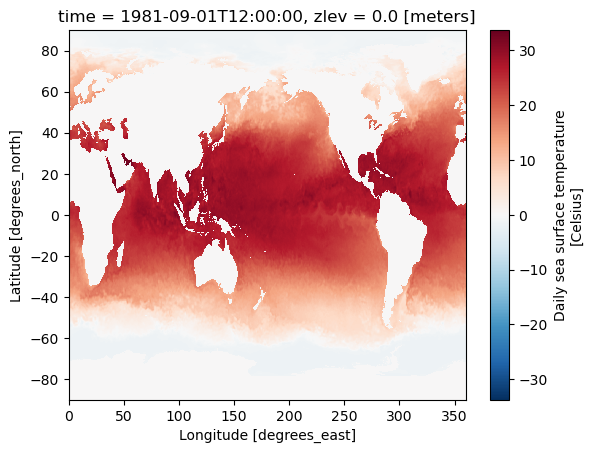

In [19]:
ds.sst[0].plot()

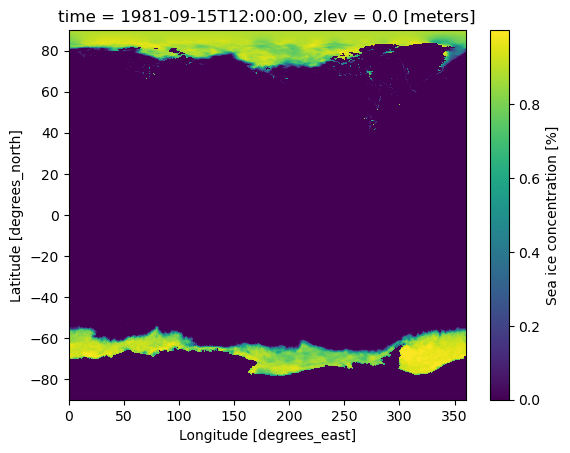

In [20]:
ds.ice[-1].plot()

## Postscript: Execute the full recipe

We are now confident that our recipe works as we expect.
At this point we could either:
- Execute it all ourselves (see {doc}`../../recipe_user_guide/execution`)
- Make a {doc}`../../../pangeo_forge_cloud/recipe_contribution` to {doc}`../../../pangeo_forge_cloud/index` to have our recipe executed automatically on the cloud.

Hopefully now you have a better understanding of how Pangeo Forge recipes work.